# 🐝 Bee Detection with YOLOv10 (Drone vs Worker)

**Goal:** Train and evaluate a YOLOv10 model to detect two bee classes — **Drone** and **Worker** — with clean splits (train/val/test) and clear metrics (mAP, precision/recall, confusion matrix).

**Key points**
- Classes: `0 = Drone`, `1 = Worker`
- Dataset: Roboflow export (train/valid/test)

**Augmentations**
- Grayscale (subset of images) → learn texture/shape beyond color
- Noise (small % of pixels) → tolerate camera artifacts / compression

### 1. Install necessary packages


In [ ]:
! pip install -U opencv-contrib-python ultralytics roboflow

In [ ]:
!pip install roboflow --quiet

In [ ]:
import os, json
from roboflow import Roboflow
from collections import Counter
from pathlib import Path
import yaml
from IPython.display import Image
from ultralytics import YOLO

In [ ]:
!nvidia-smi

Wed Nov  5 12:12:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2. Loading data

In [ ]:
# Shows project slugs
API_KEY = "Enter your API"
rf = Roboflow(api_key=API_KEY)
ws = rf.workspace()
print(ws)

In [ ]:
# Loading dataset from Roboflow
project = rf.workspace("workspace").project("project")
version = project.version(6)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to My-First-Project-6 in yolov8:: 100%|██████████| 152/152 [00:00<00:00, 5710.98it/s]


In [ ]:
base = Path("/content/My-First-Project-6")

print("IMAGE COUNTS BEFORE FILTERING:")
for split in ["train", "valid", "test"]:
    img_dir = base / split / "images"
    num_images = len(list(img_dir.glob("*.jpg"))) + len(list(img_dir.glob("*.png")))
    print(f"  {split}: {num_images} images")

IMAGE COUNTS BEFORE FILTERING:
  train: 60 images
  valid: 5 images
  test: 5 images


In [ ]:
# Get to know the ratio in our dataset
worker_count = 0
drone_count  = 0
worker_idx = 1
drone_idx = 0
for split in ["train", "valid"]:
    lbl_dir = base / split / "labels"
    for lbl_file in lbl_dir.glob("*.txt"):
        with open(lbl_file, "r") as f:
            labels = [line.strip().split()[0] for line in f if line.strip()]
        cls_ids = [int(idx) for idx in labels]
        worker_count += cls_ids.count(worker_idx) if worker_idx is not None else 0
        drone_count  += cls_ids.count(drone_idx)  if drone_idx is not None else 0
print(f"🐝 Worker:Drone ratio = {worker_count/drone_count:.2f}:1")

🐝 Worker:Drone ratio = 34.30:1


### 3. Training model

In [ ]:
# trains yolov10s.pt
data_yaml = Path("/content/My-First-Project-6/data.yaml")
model = YOLO("yolov10s.pt")

results = model.train(
    data=str(data_yaml),
    epochs=50,
    imgsz=640,
    batch=8,
    project="/content/yolo10_runs_version6",
    name="bee_imbalance",
    exist_ok=True,
    cache=True,
    lr0=0.005,
    warmup_epochs=3,
    patience=7,
)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/My-First-Project-6/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov10s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=bee_imbalance, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=7, perspective=0.0, plot

### 4. Result



📊 results.png


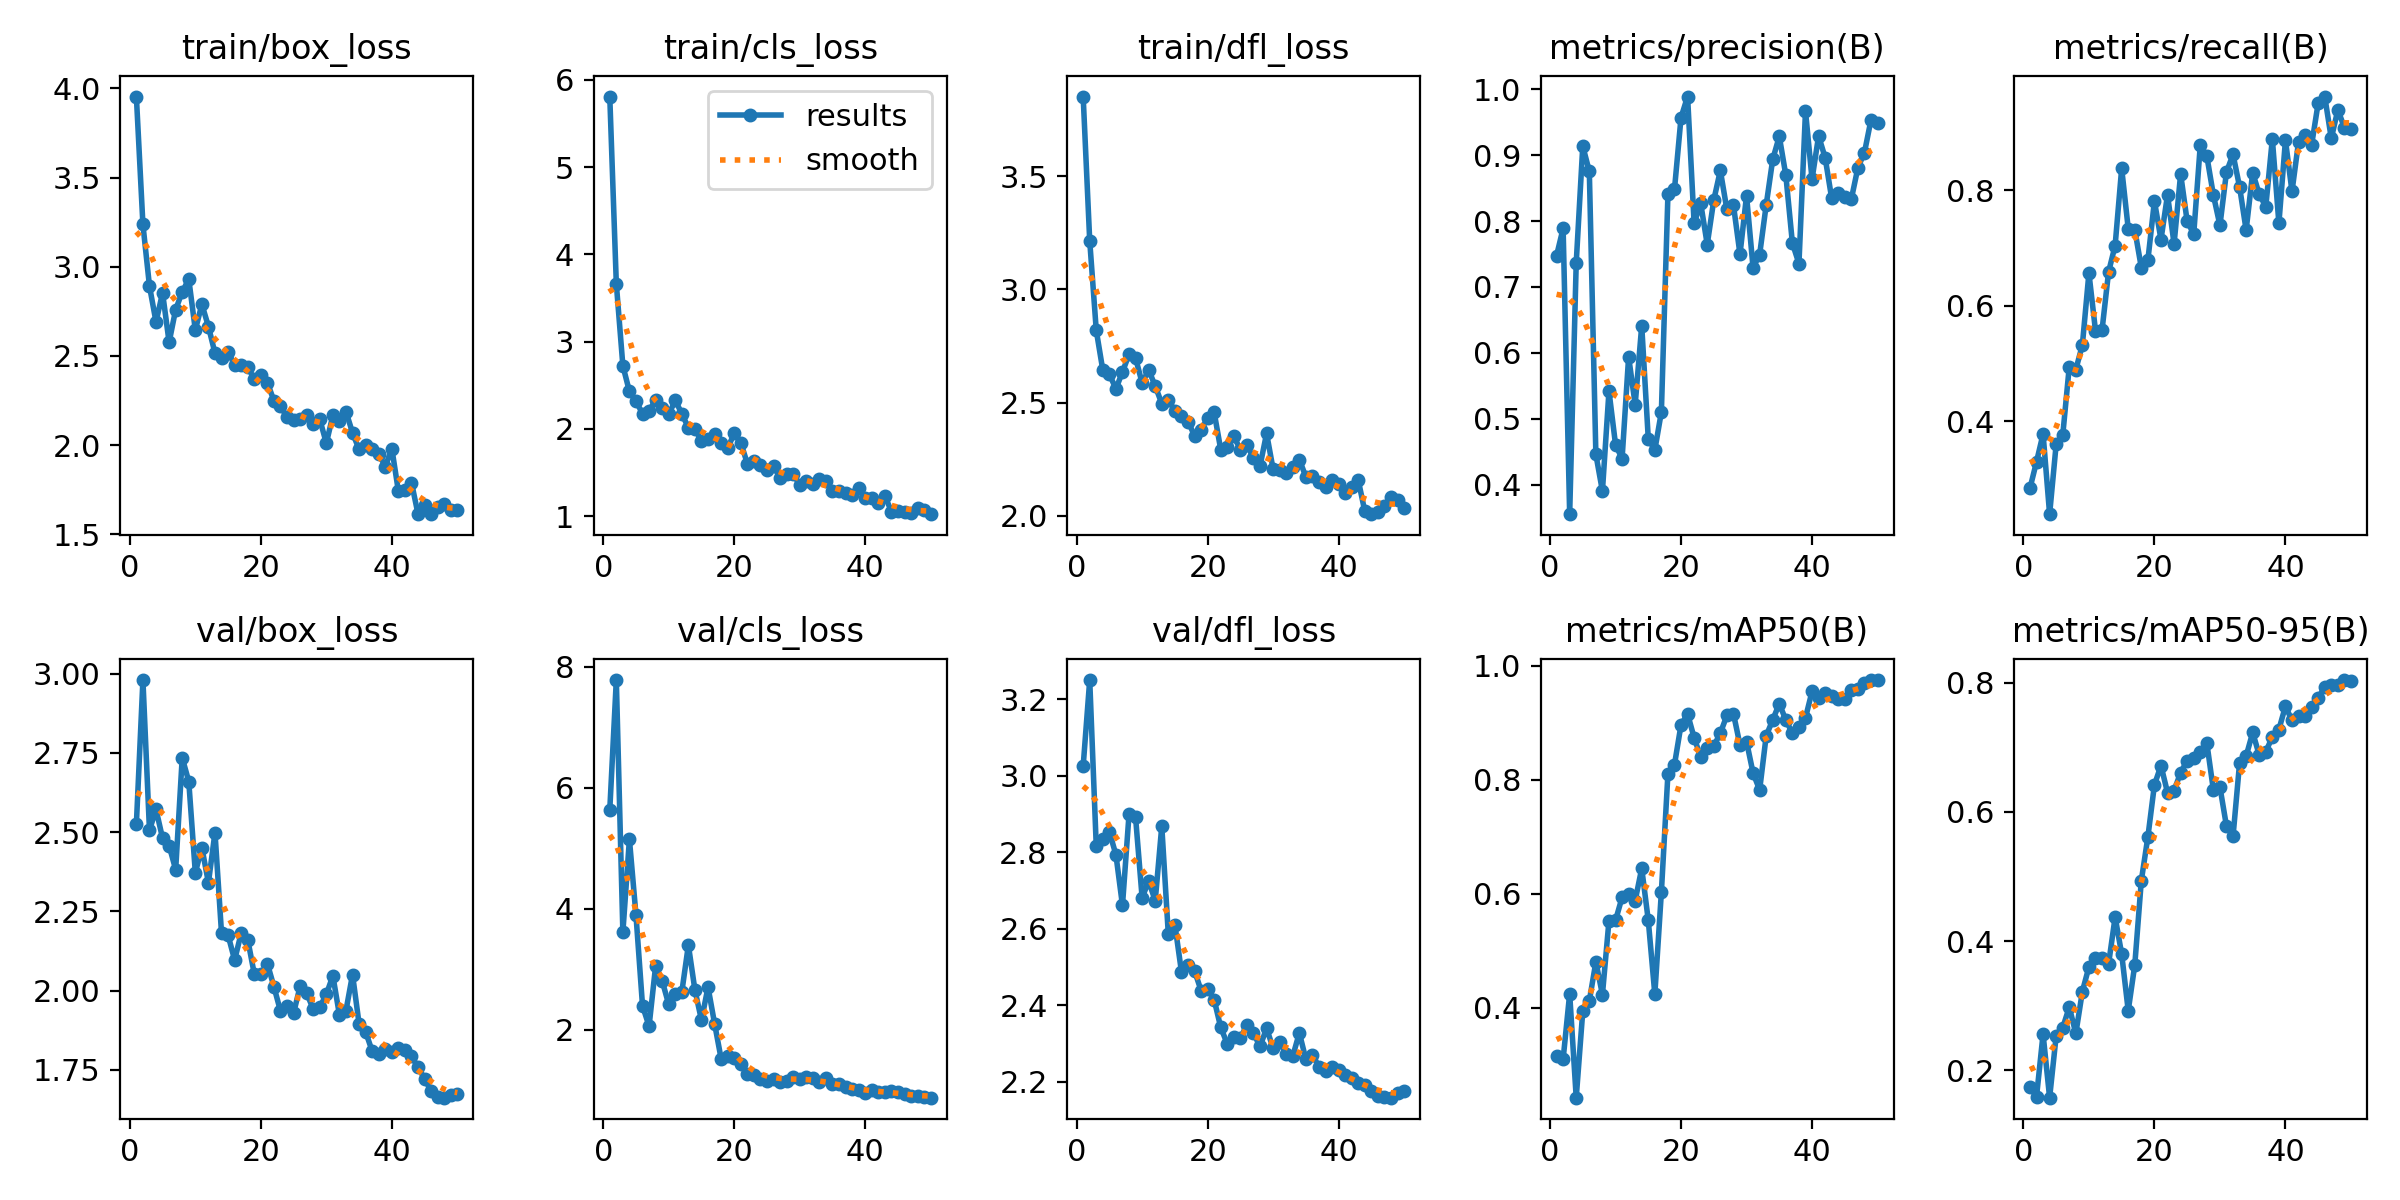


📊 confusion_matrix.png


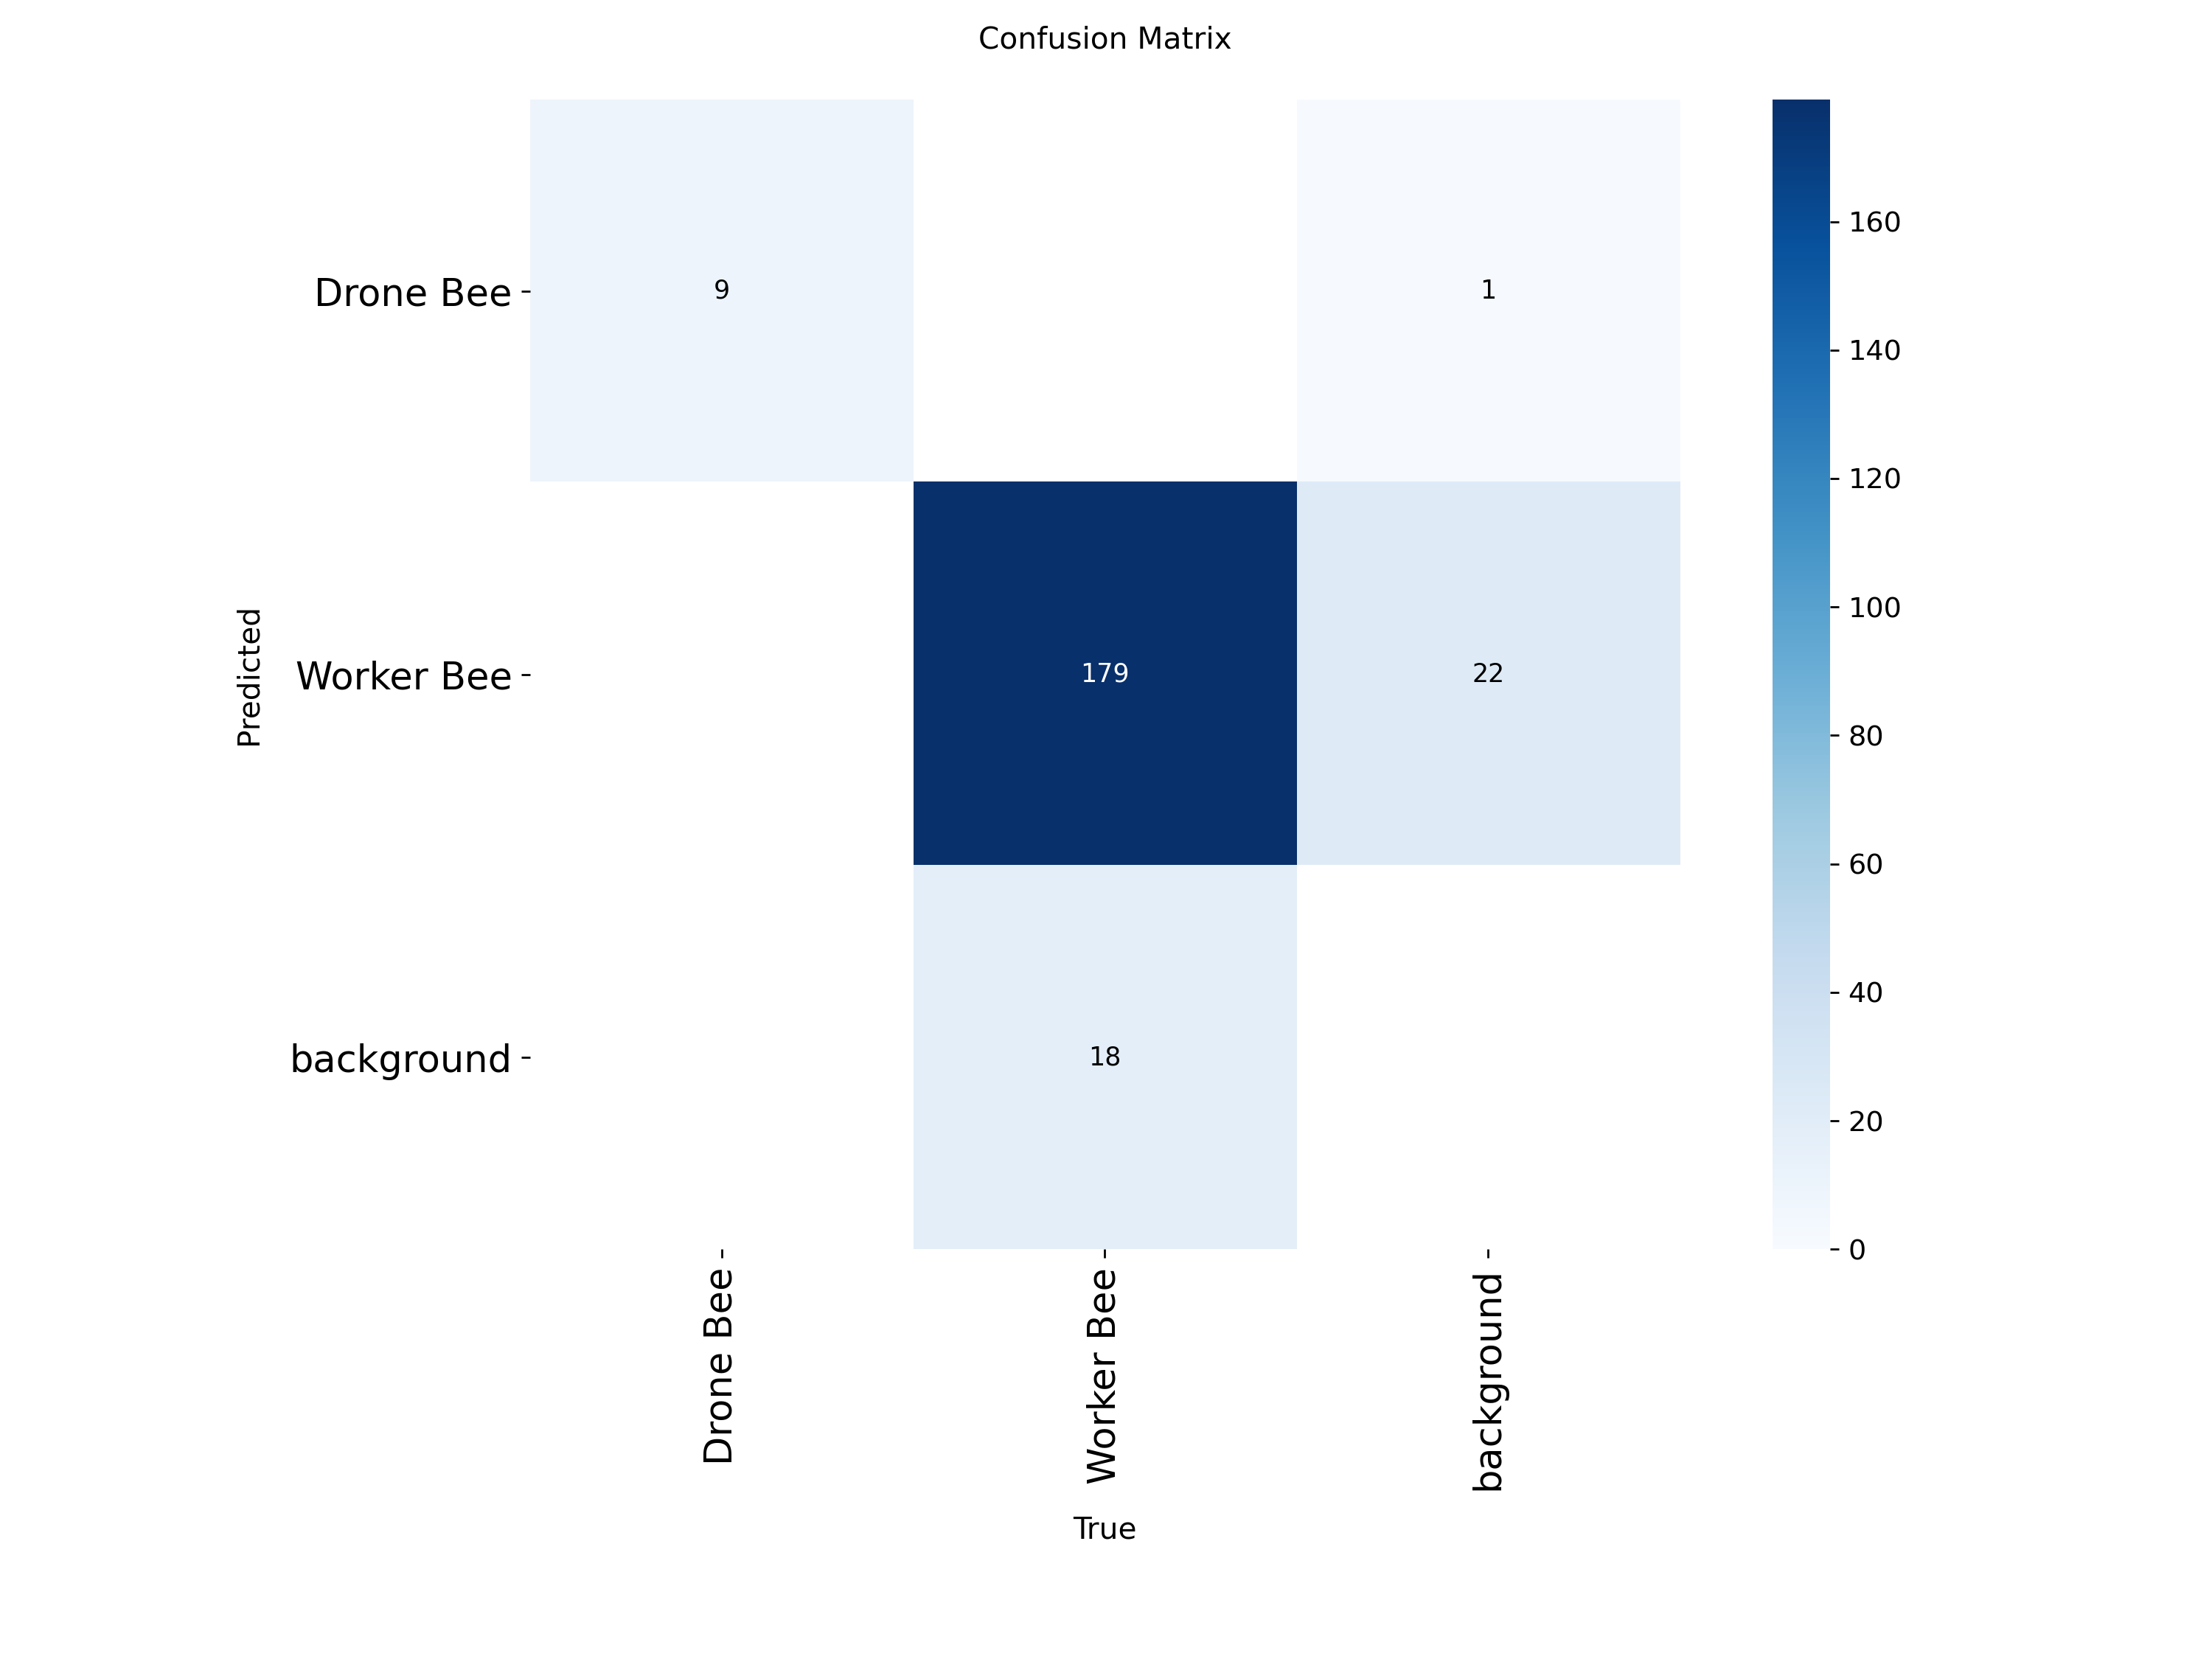


📊 confusion_matrix_normalized.png


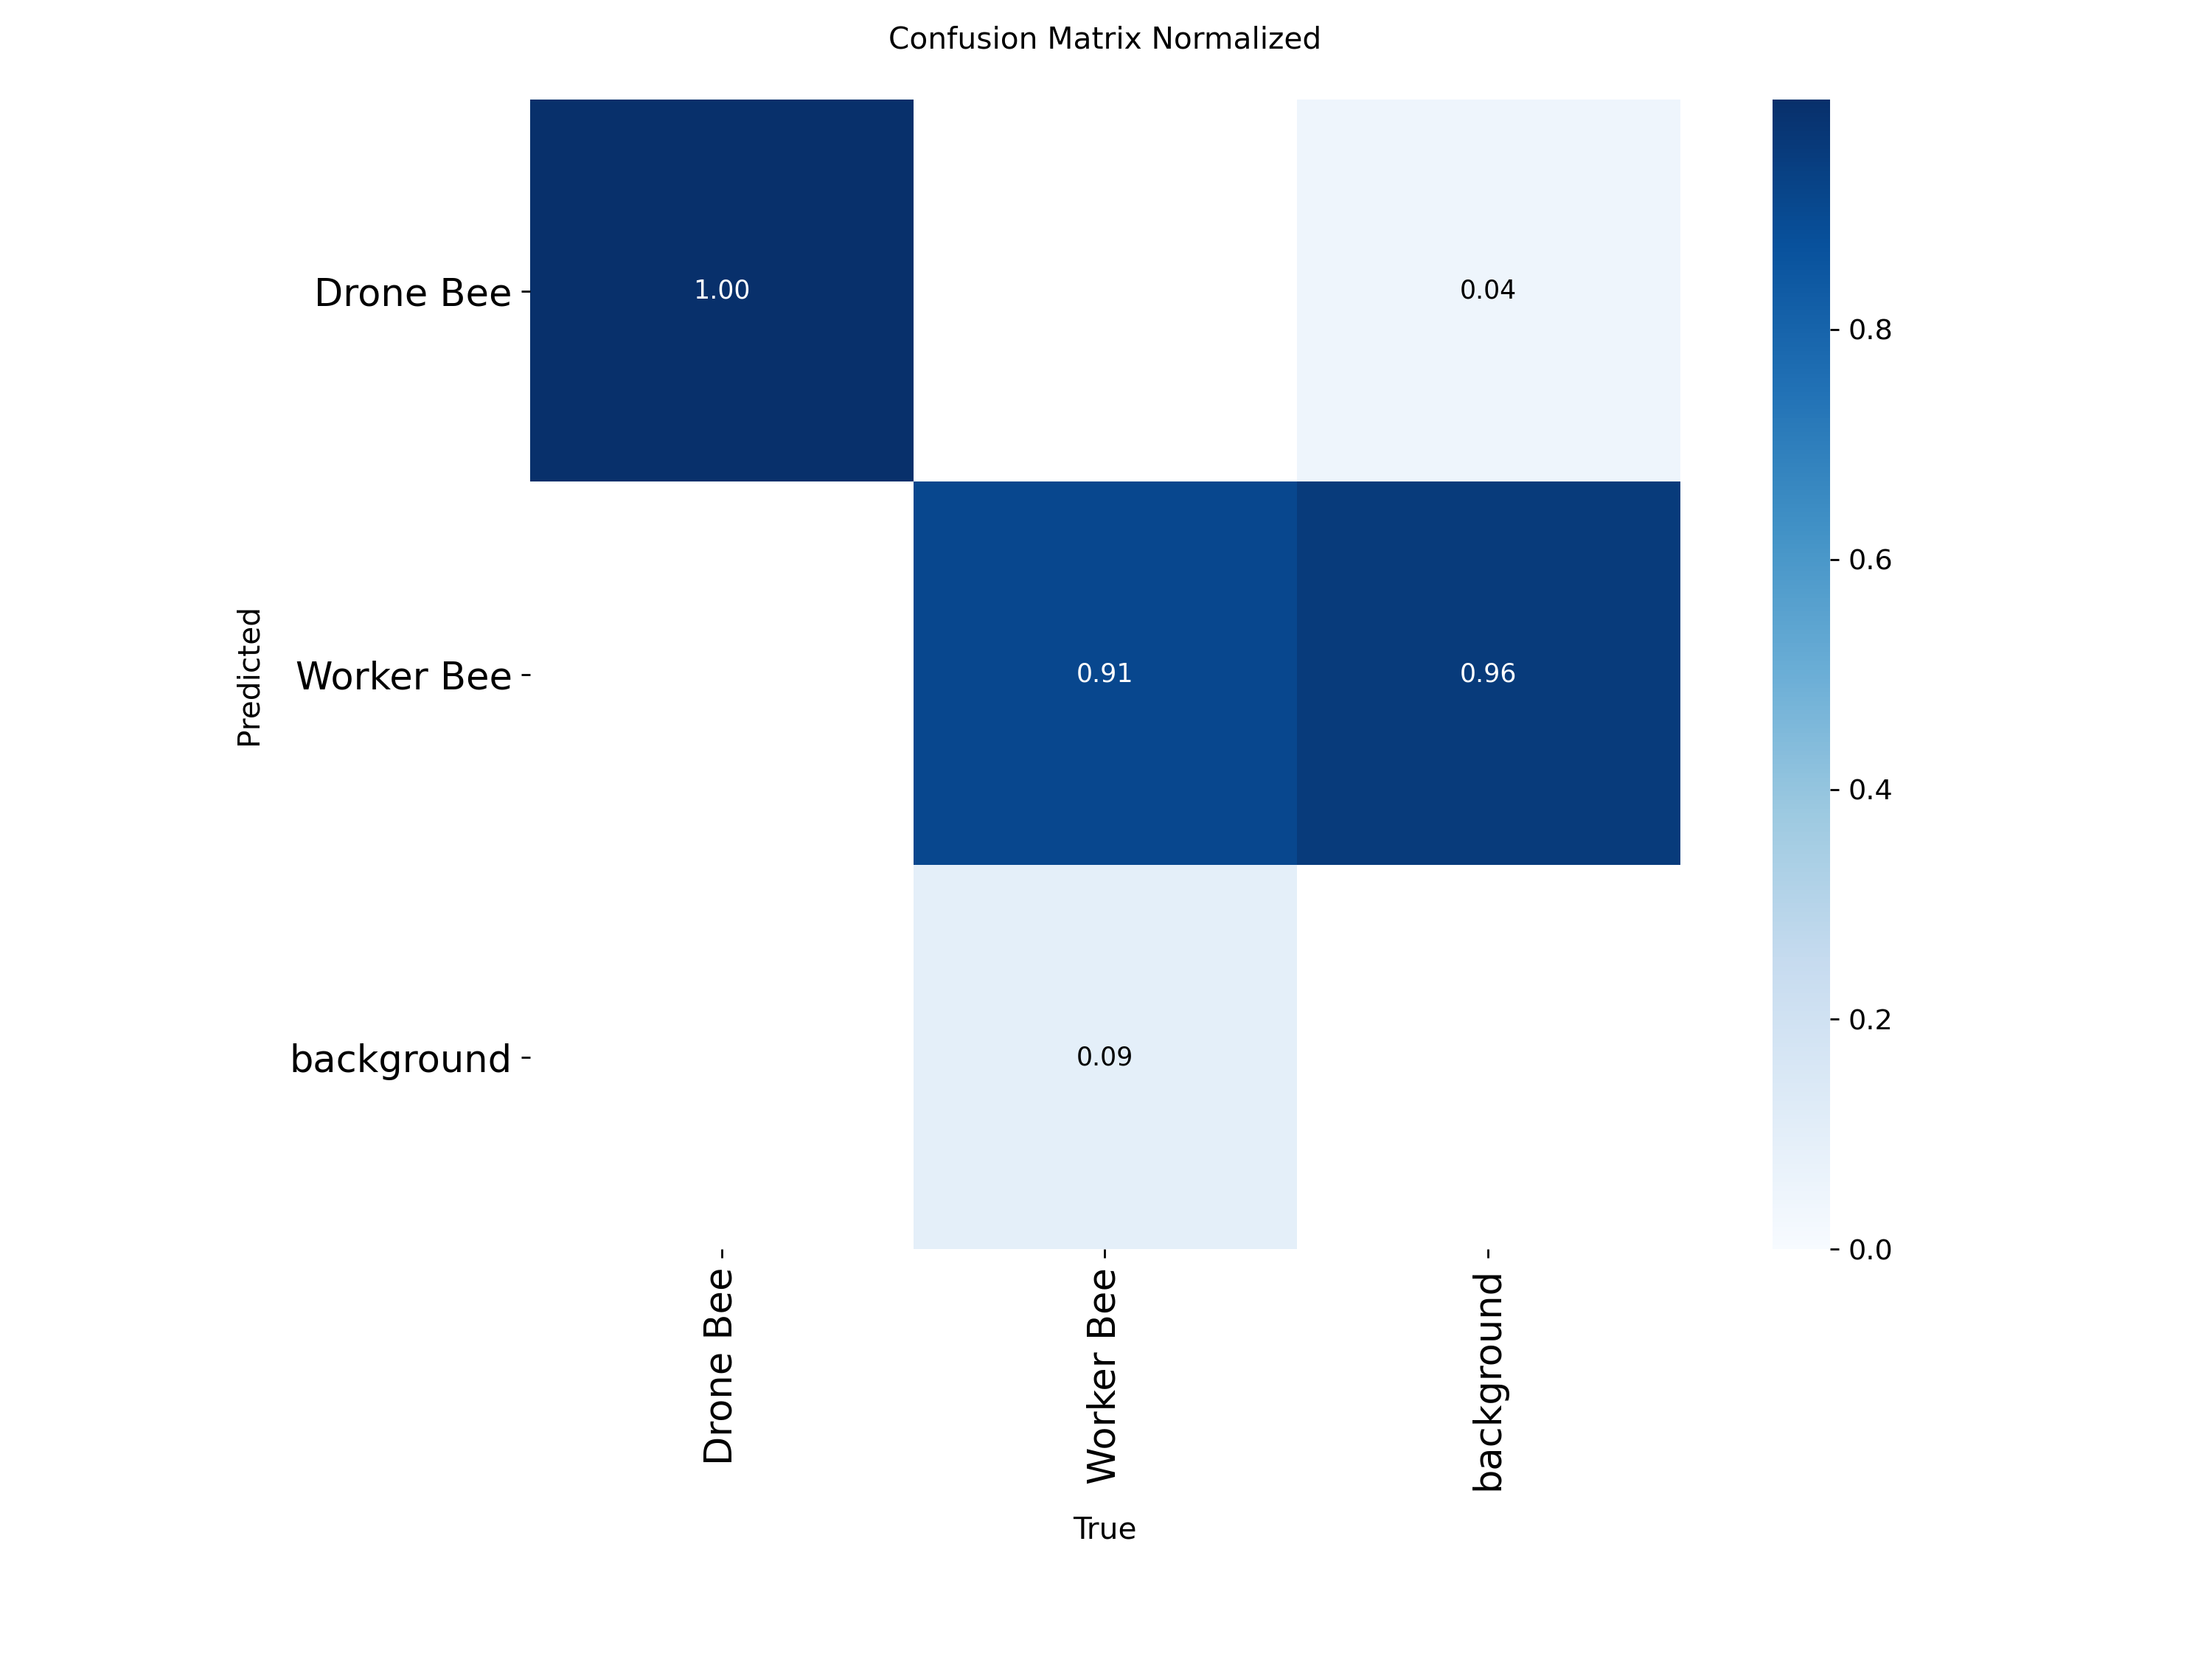


📊 BoxF1_curve.png


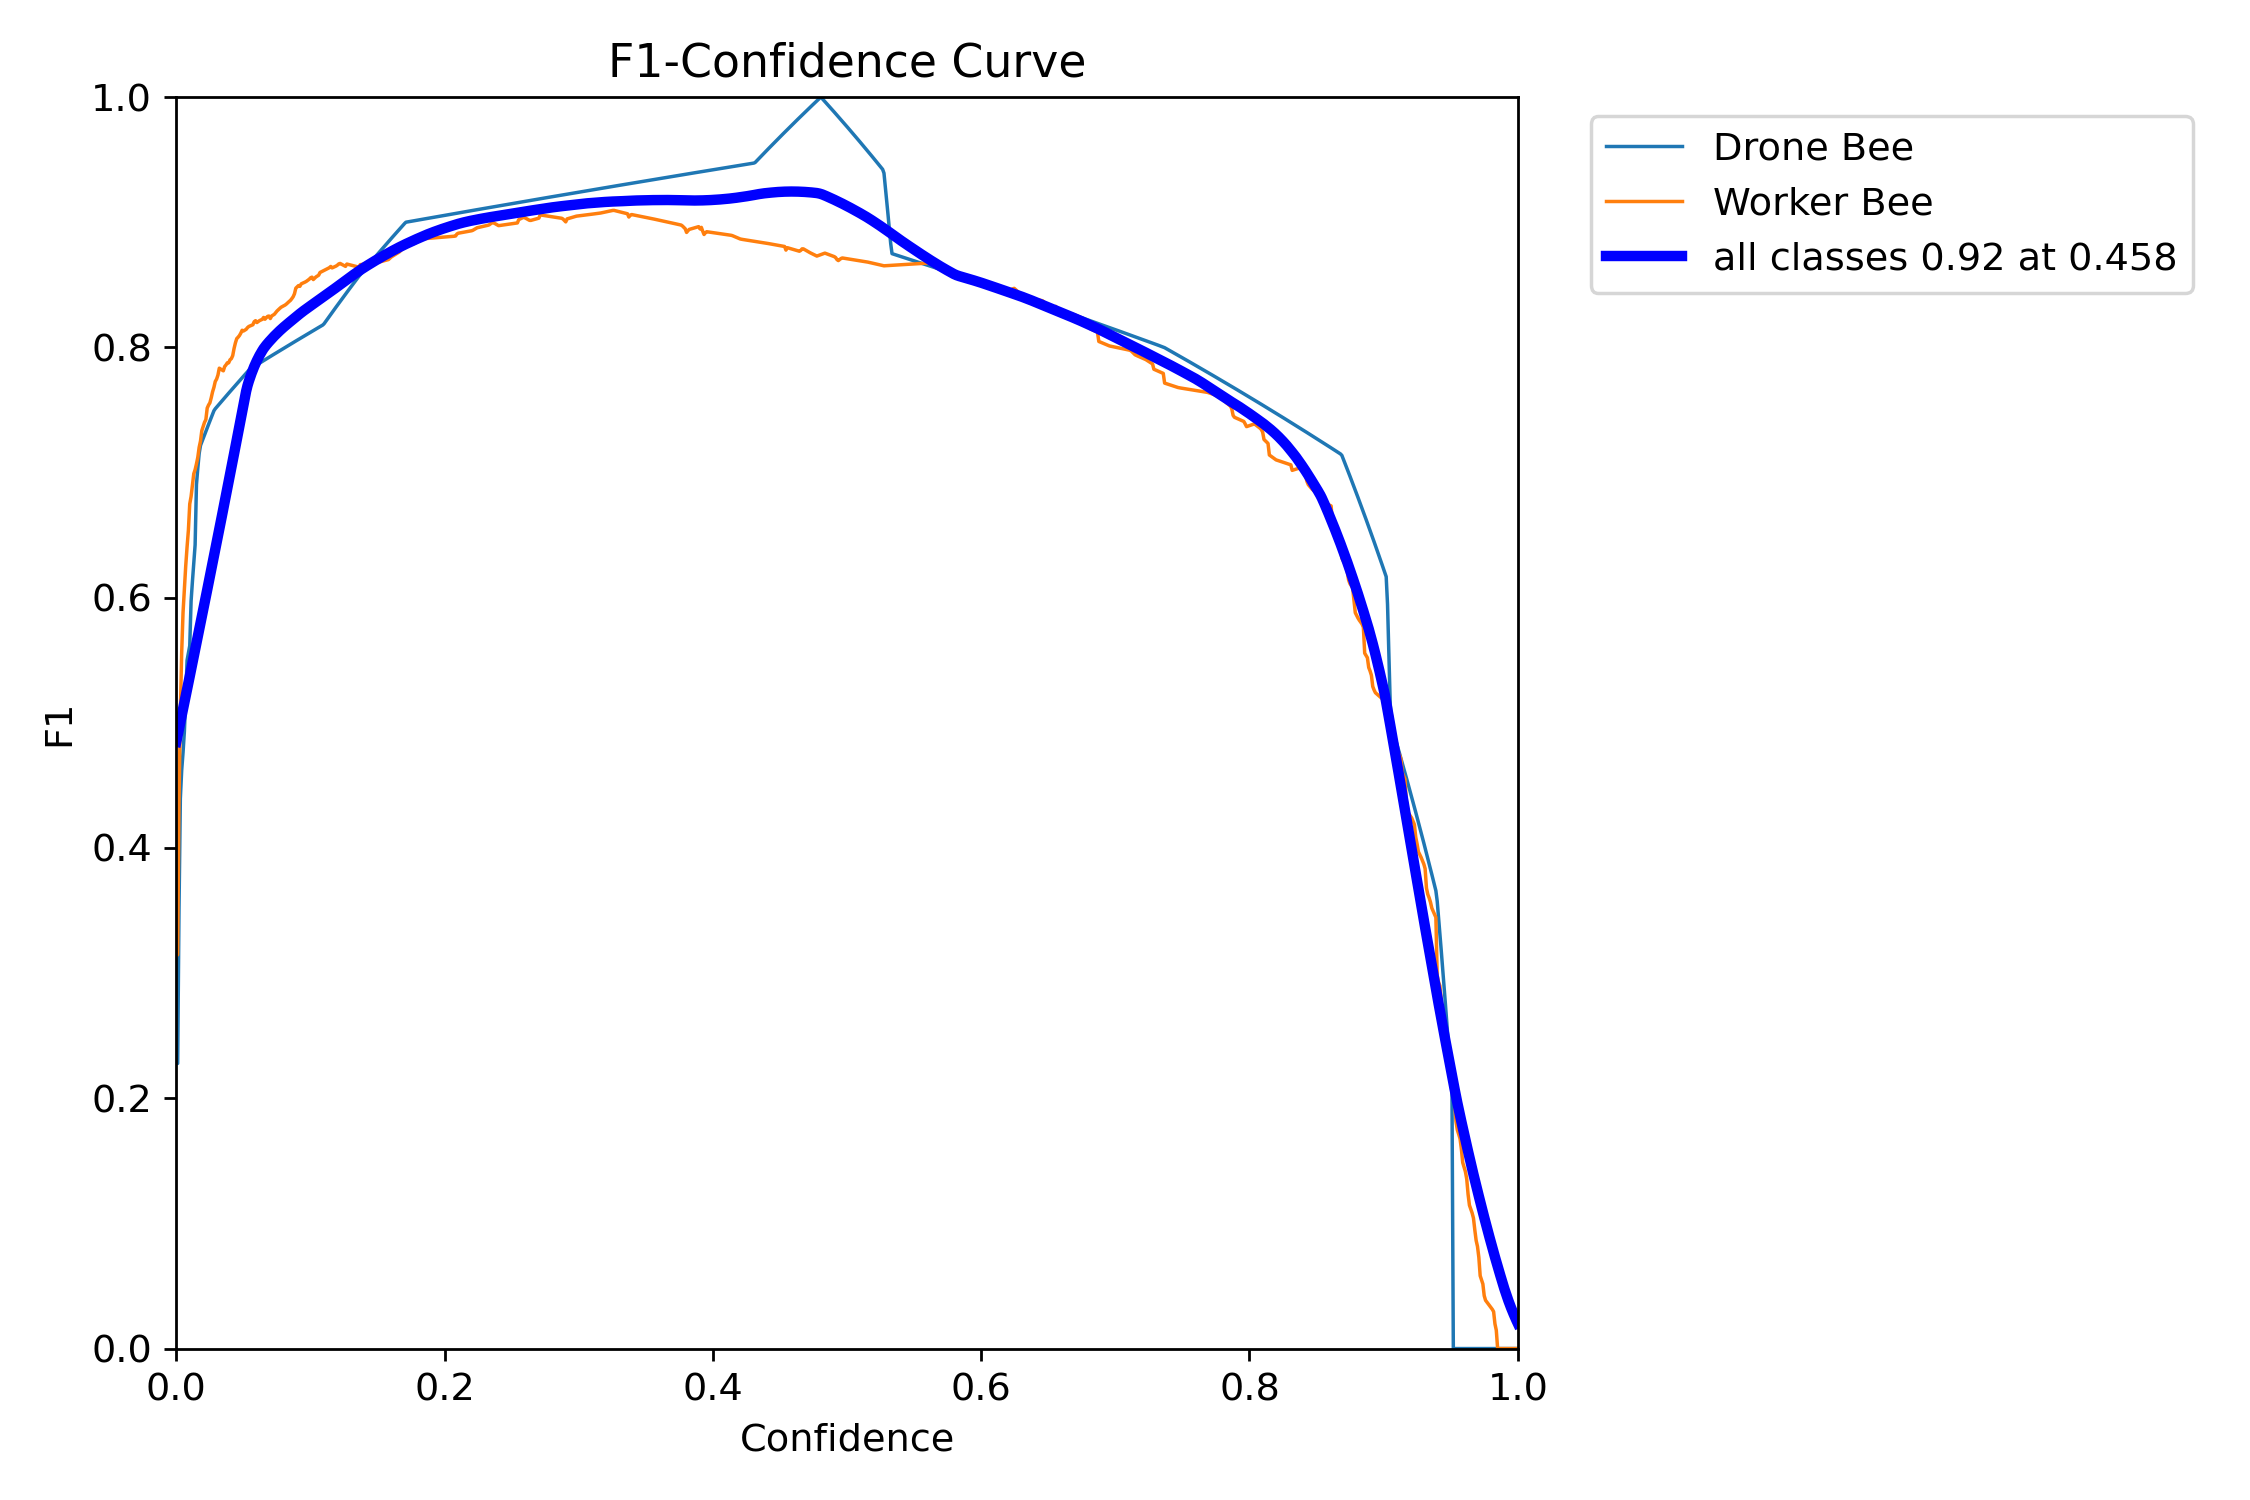


📊 BoxP_curve.png


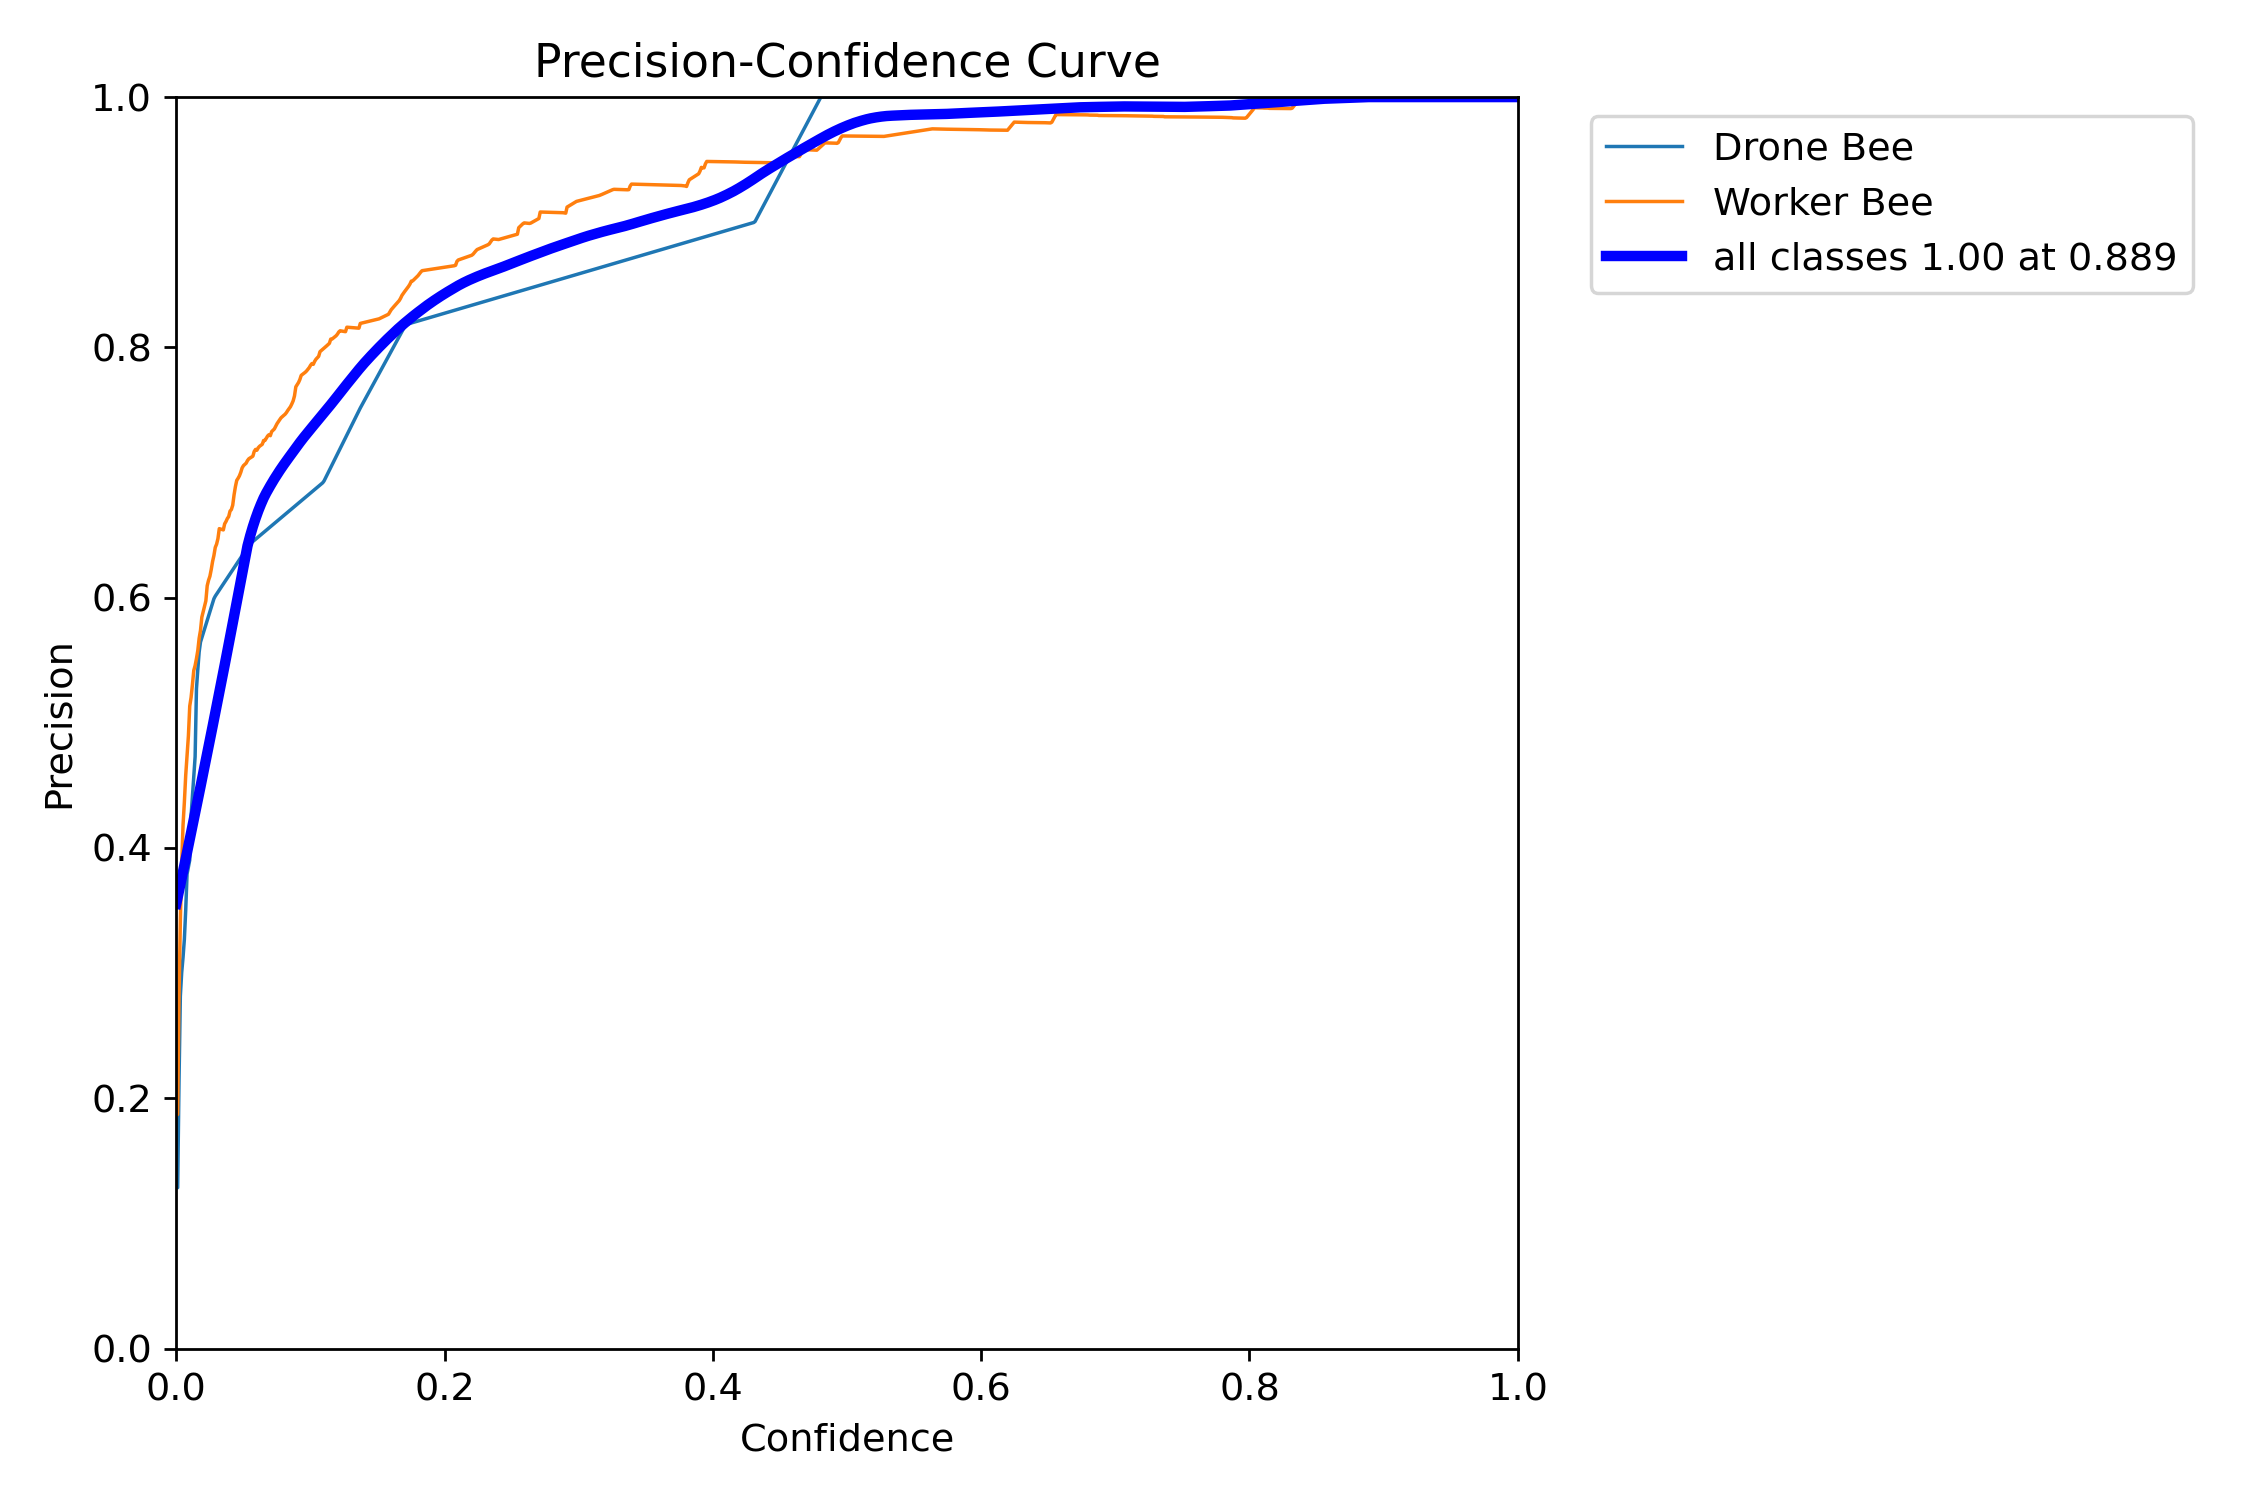


📊 BoxR_curve.png


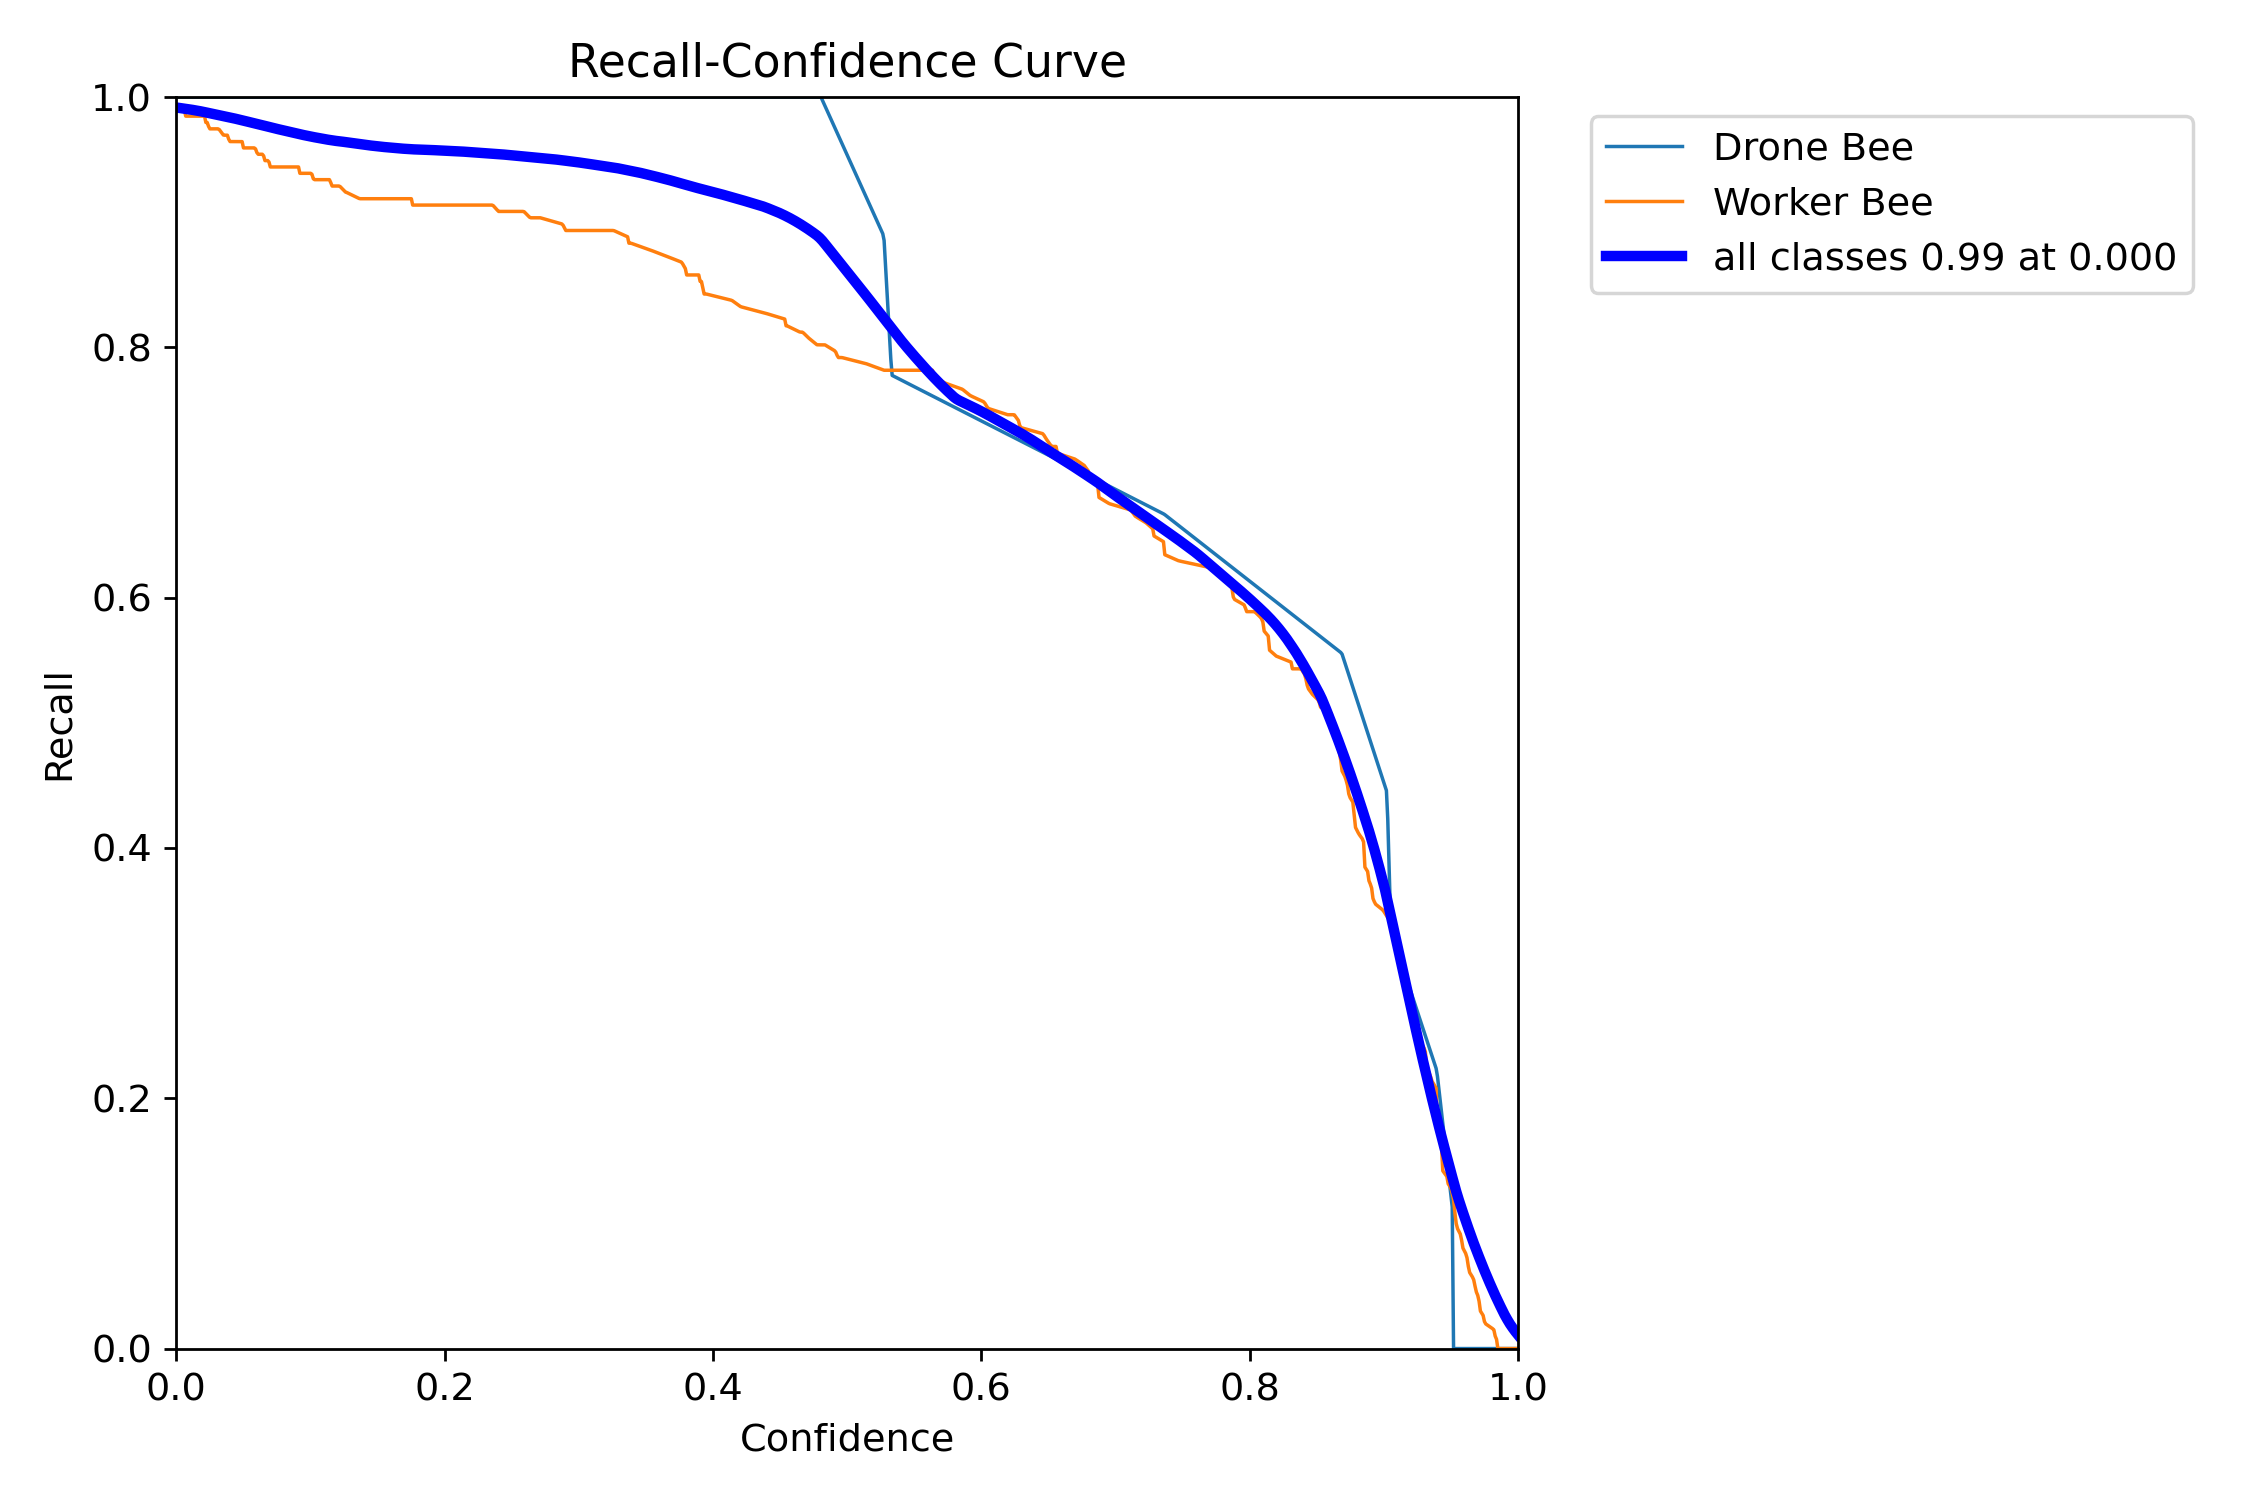


📊 BoxPR_curve.png


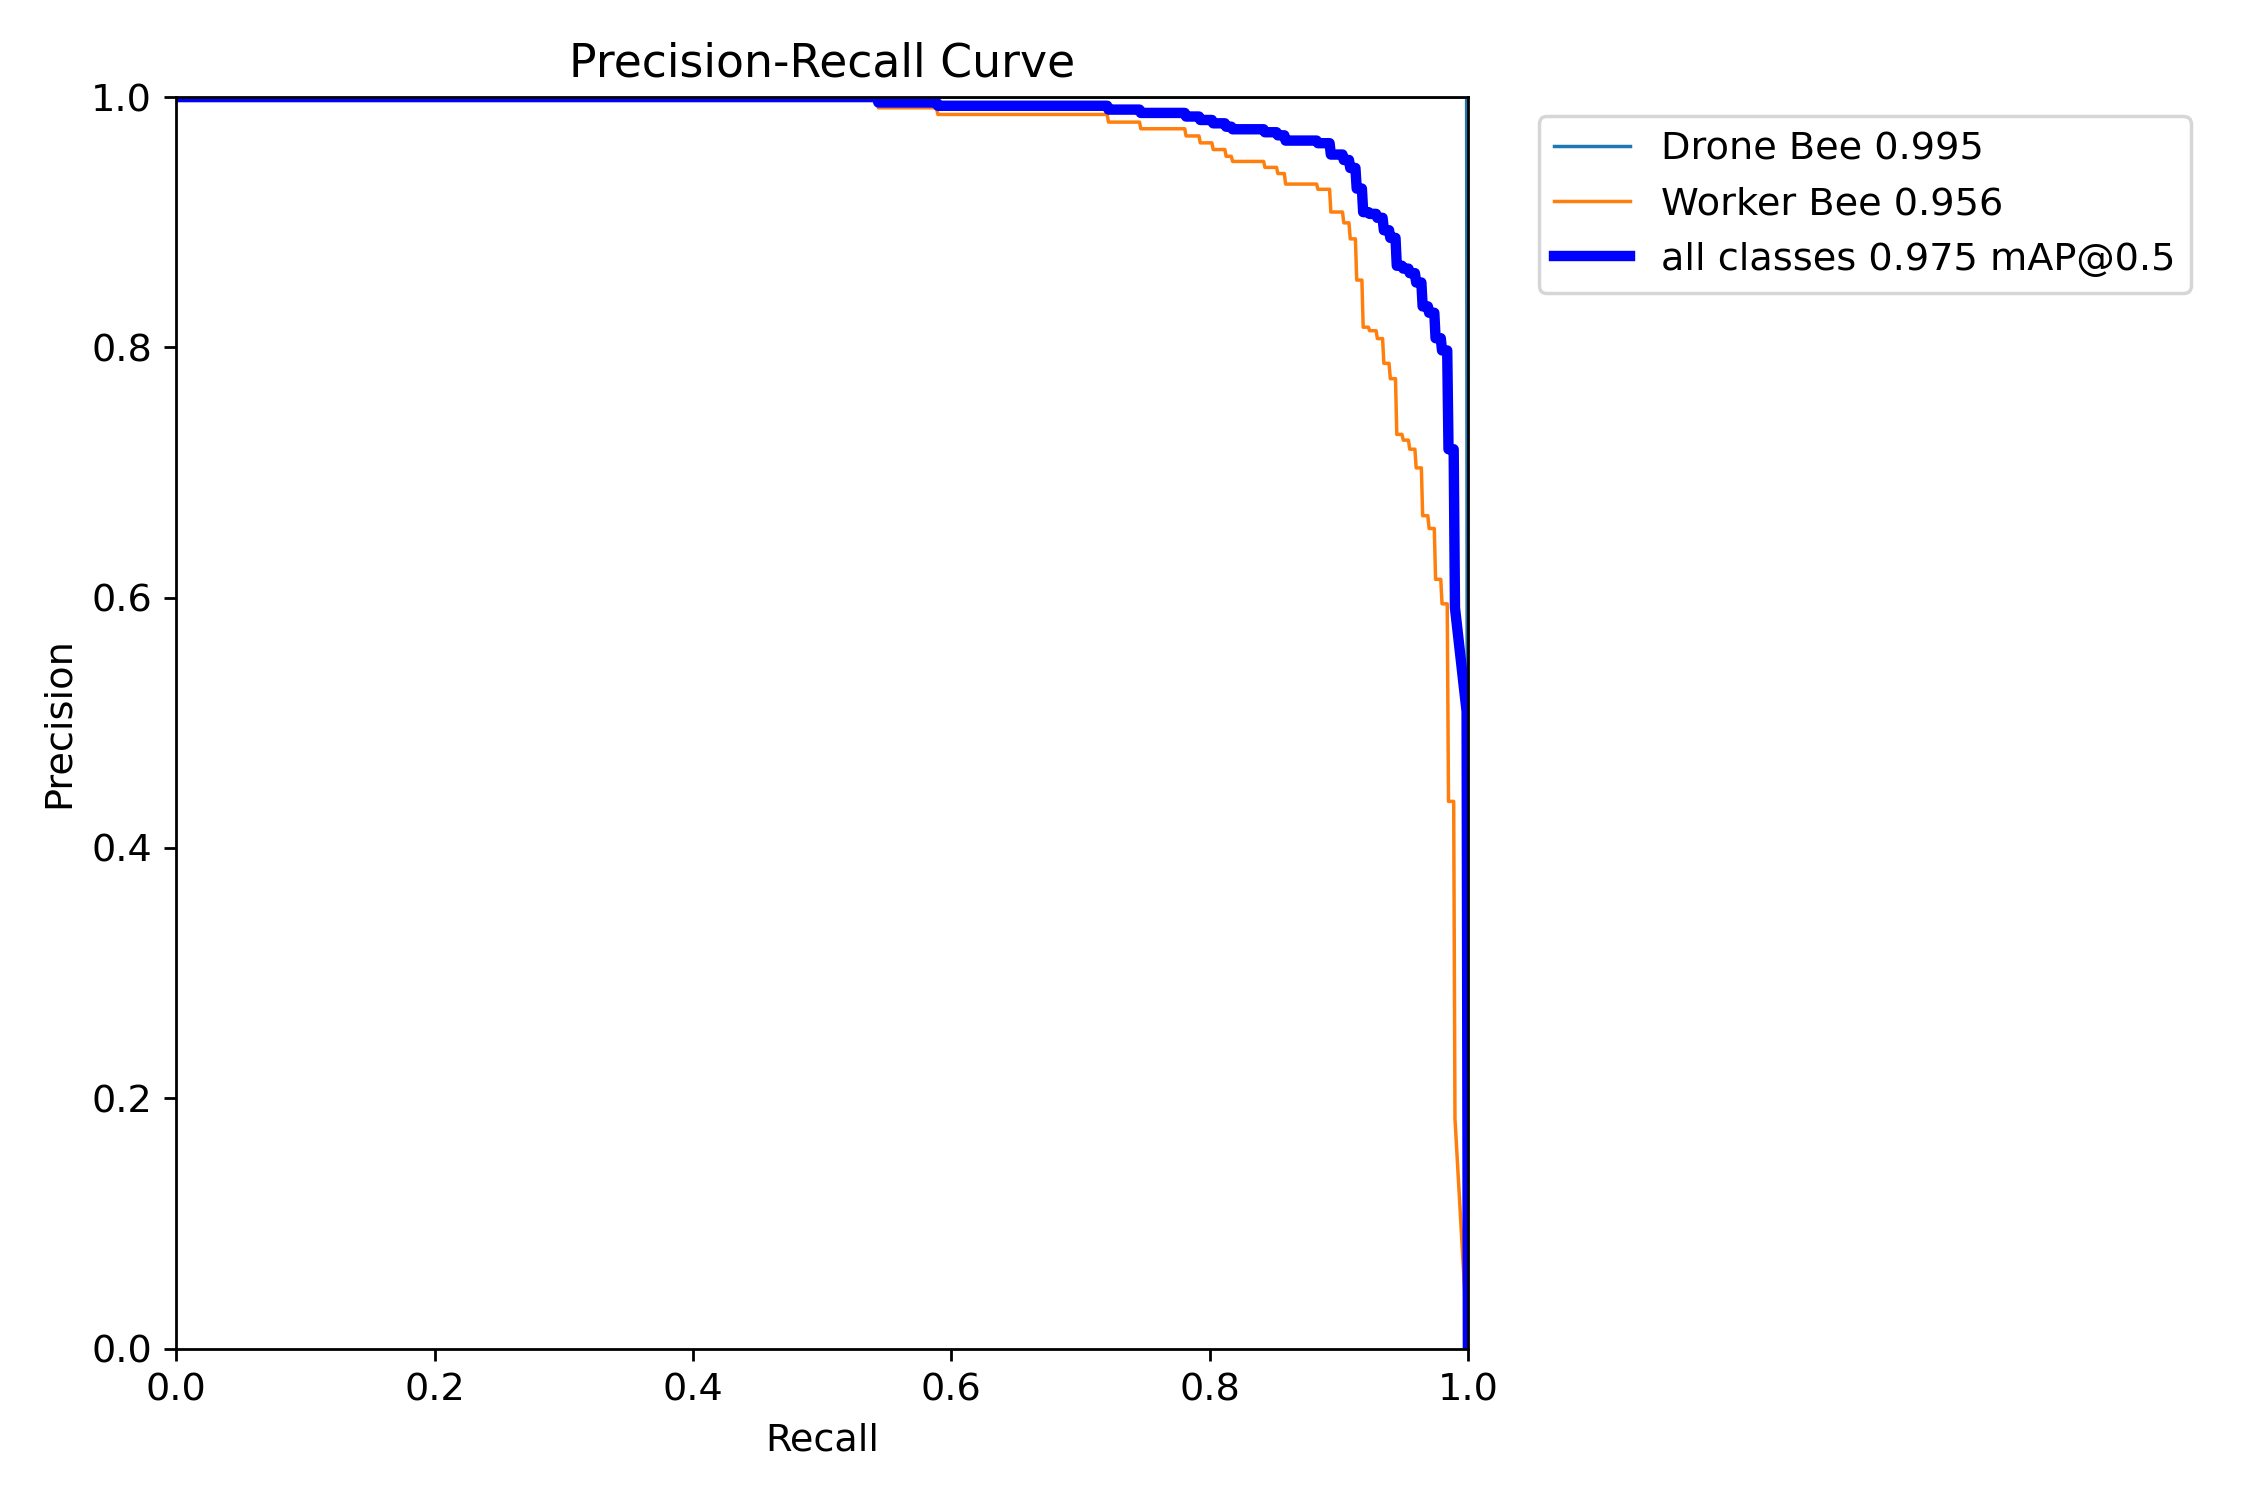


📊 labels.jpg


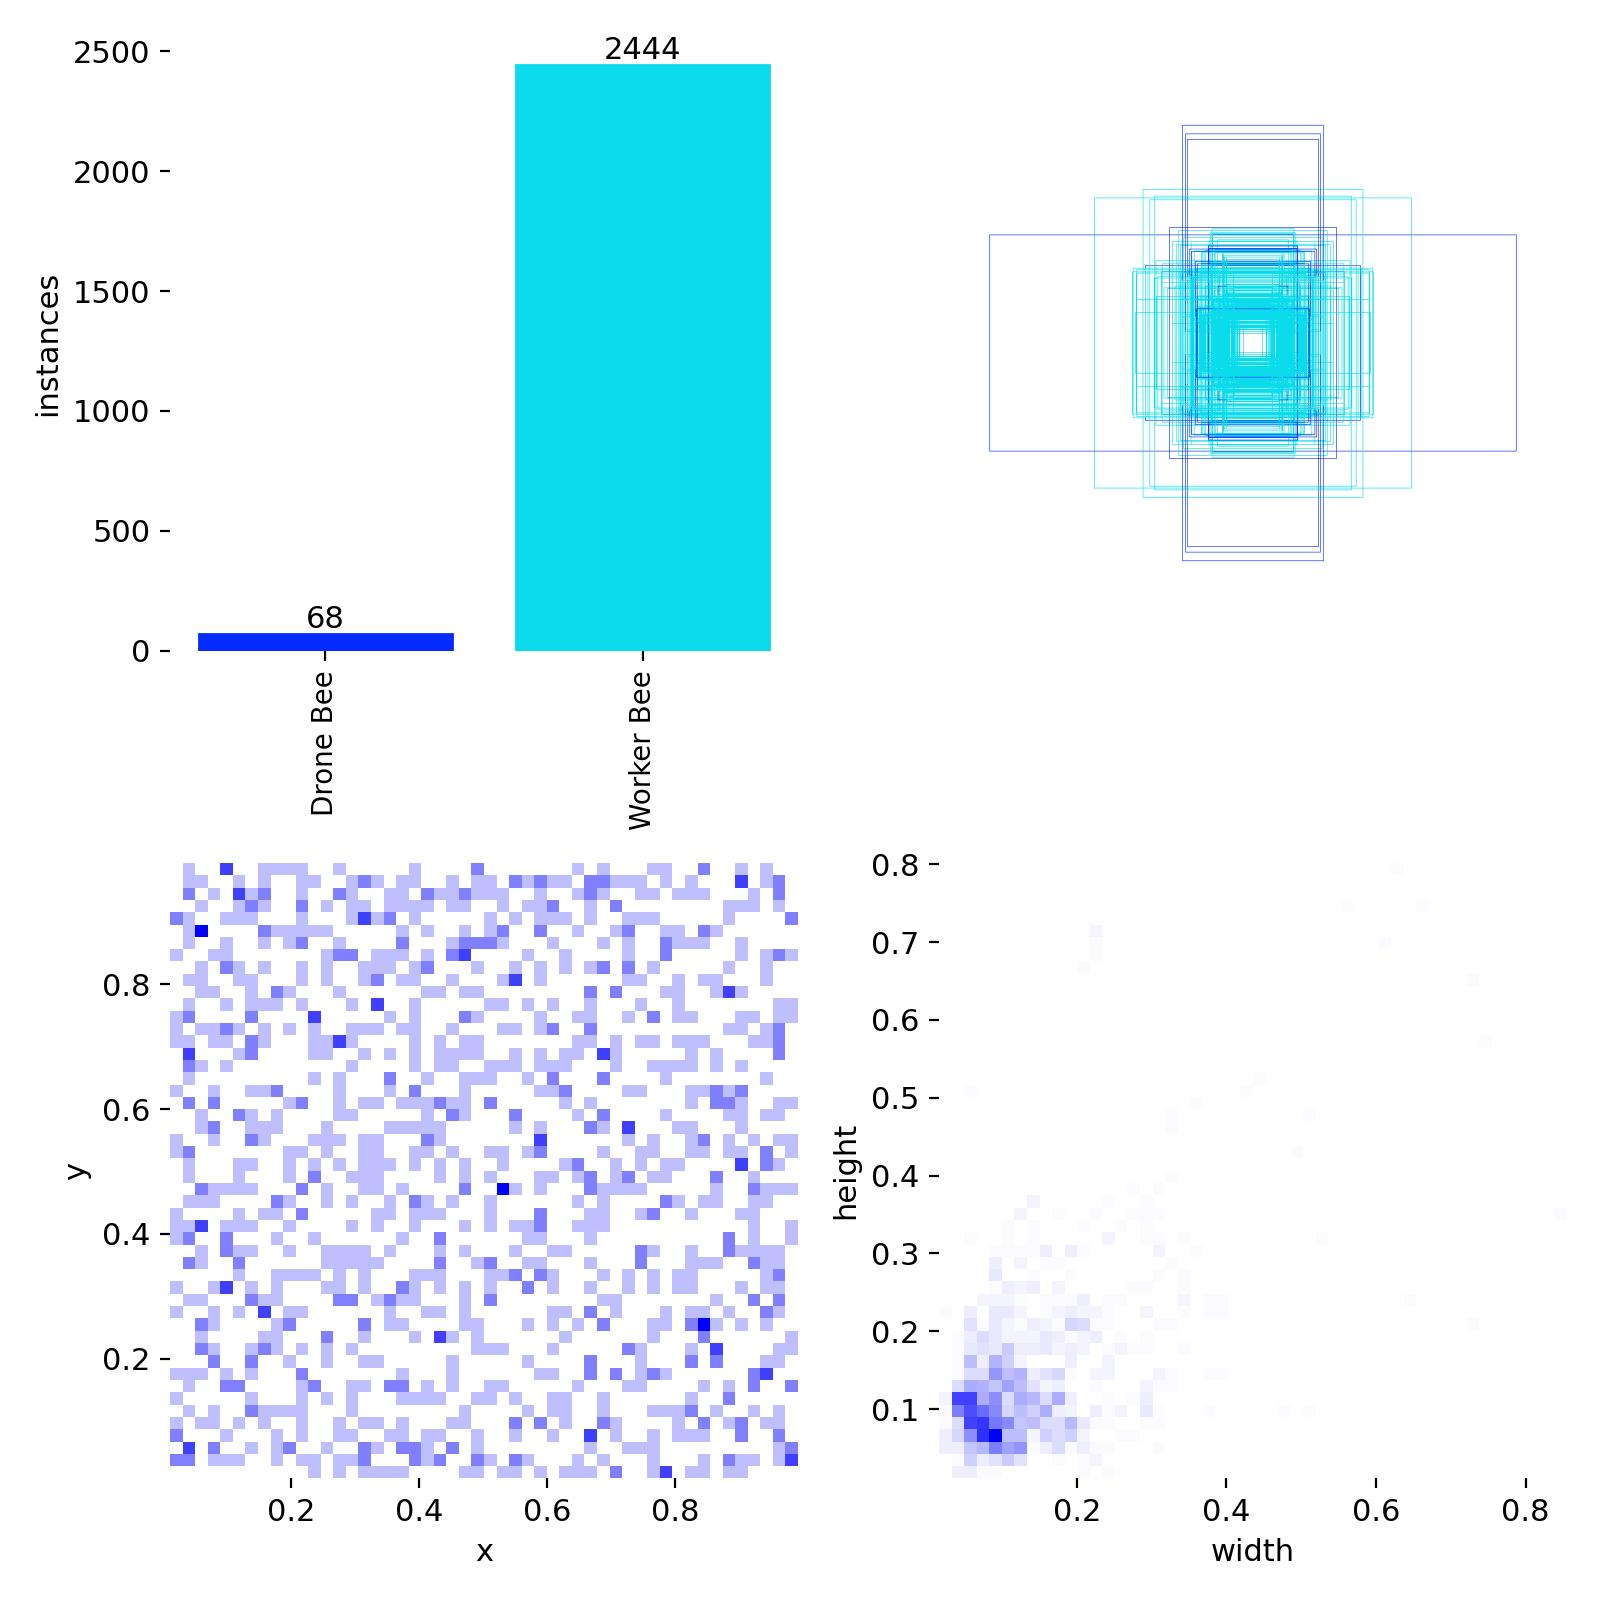

In [ ]:
# Shows performance on the trainning images
training_images = [
    "results.png",
    "confusion_matrix.png",
    "confusion_matrix_normalized.png",
    "BoxF1_curve.png",
    "BoxP_curve.png",
    "BoxR_curve.png",
    "BoxPR_curve.png",
    "labels.jpg",

]


for img in training_images:
    path = f"/content/yolo10_runs_version6/bee_imbalance/{img}"
    try:
        print(f"\n📊 {img}")
        display(Image(filename=path))
    except:
        print(f"❌ {img} not found")

In [ ]:
# Evaluates on test set
results = model.val(
    data=str(data_yaml),
    split="test",
    plots=True,
    project="yolo_test_eval",
    name="bee_test_results"
)

print("✅ Evaluation complete!")

In [ ]:
print(f"mAP50: {results.box.map50 : .2f}")
print(f"mAP50-95: {results.box.map: .2f}")
print(f"Precision: {results.box.mp: .2f}")
print(f"Recall: {results.box.mr: .2f}")

mAP50:  0.95
mAP50-95:  0.73
Precision:  0.82
Recall:  0.96


In [ ]:
print(f"\nPer-Class mAP50:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.maps[i]:.3f}")

print(f"\nPer-Class Precision:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.class_result(i)[0]:.3f}")

print(f"\nPer-Class Recall:")
for i, class_name in enumerate(['Worker', 'Drone']):
    print(f"  {class_name}: {results.box.class_result(i)[1]:.3f}")


Per-Class mAP50:
  Worker: 0.805
  Drone: 0.665

Per-Class Precision:
  Worker: 0.891
  Drone: 0.739

Per-Class Recall:
  Worker: 1.000
  Drone: 0.928


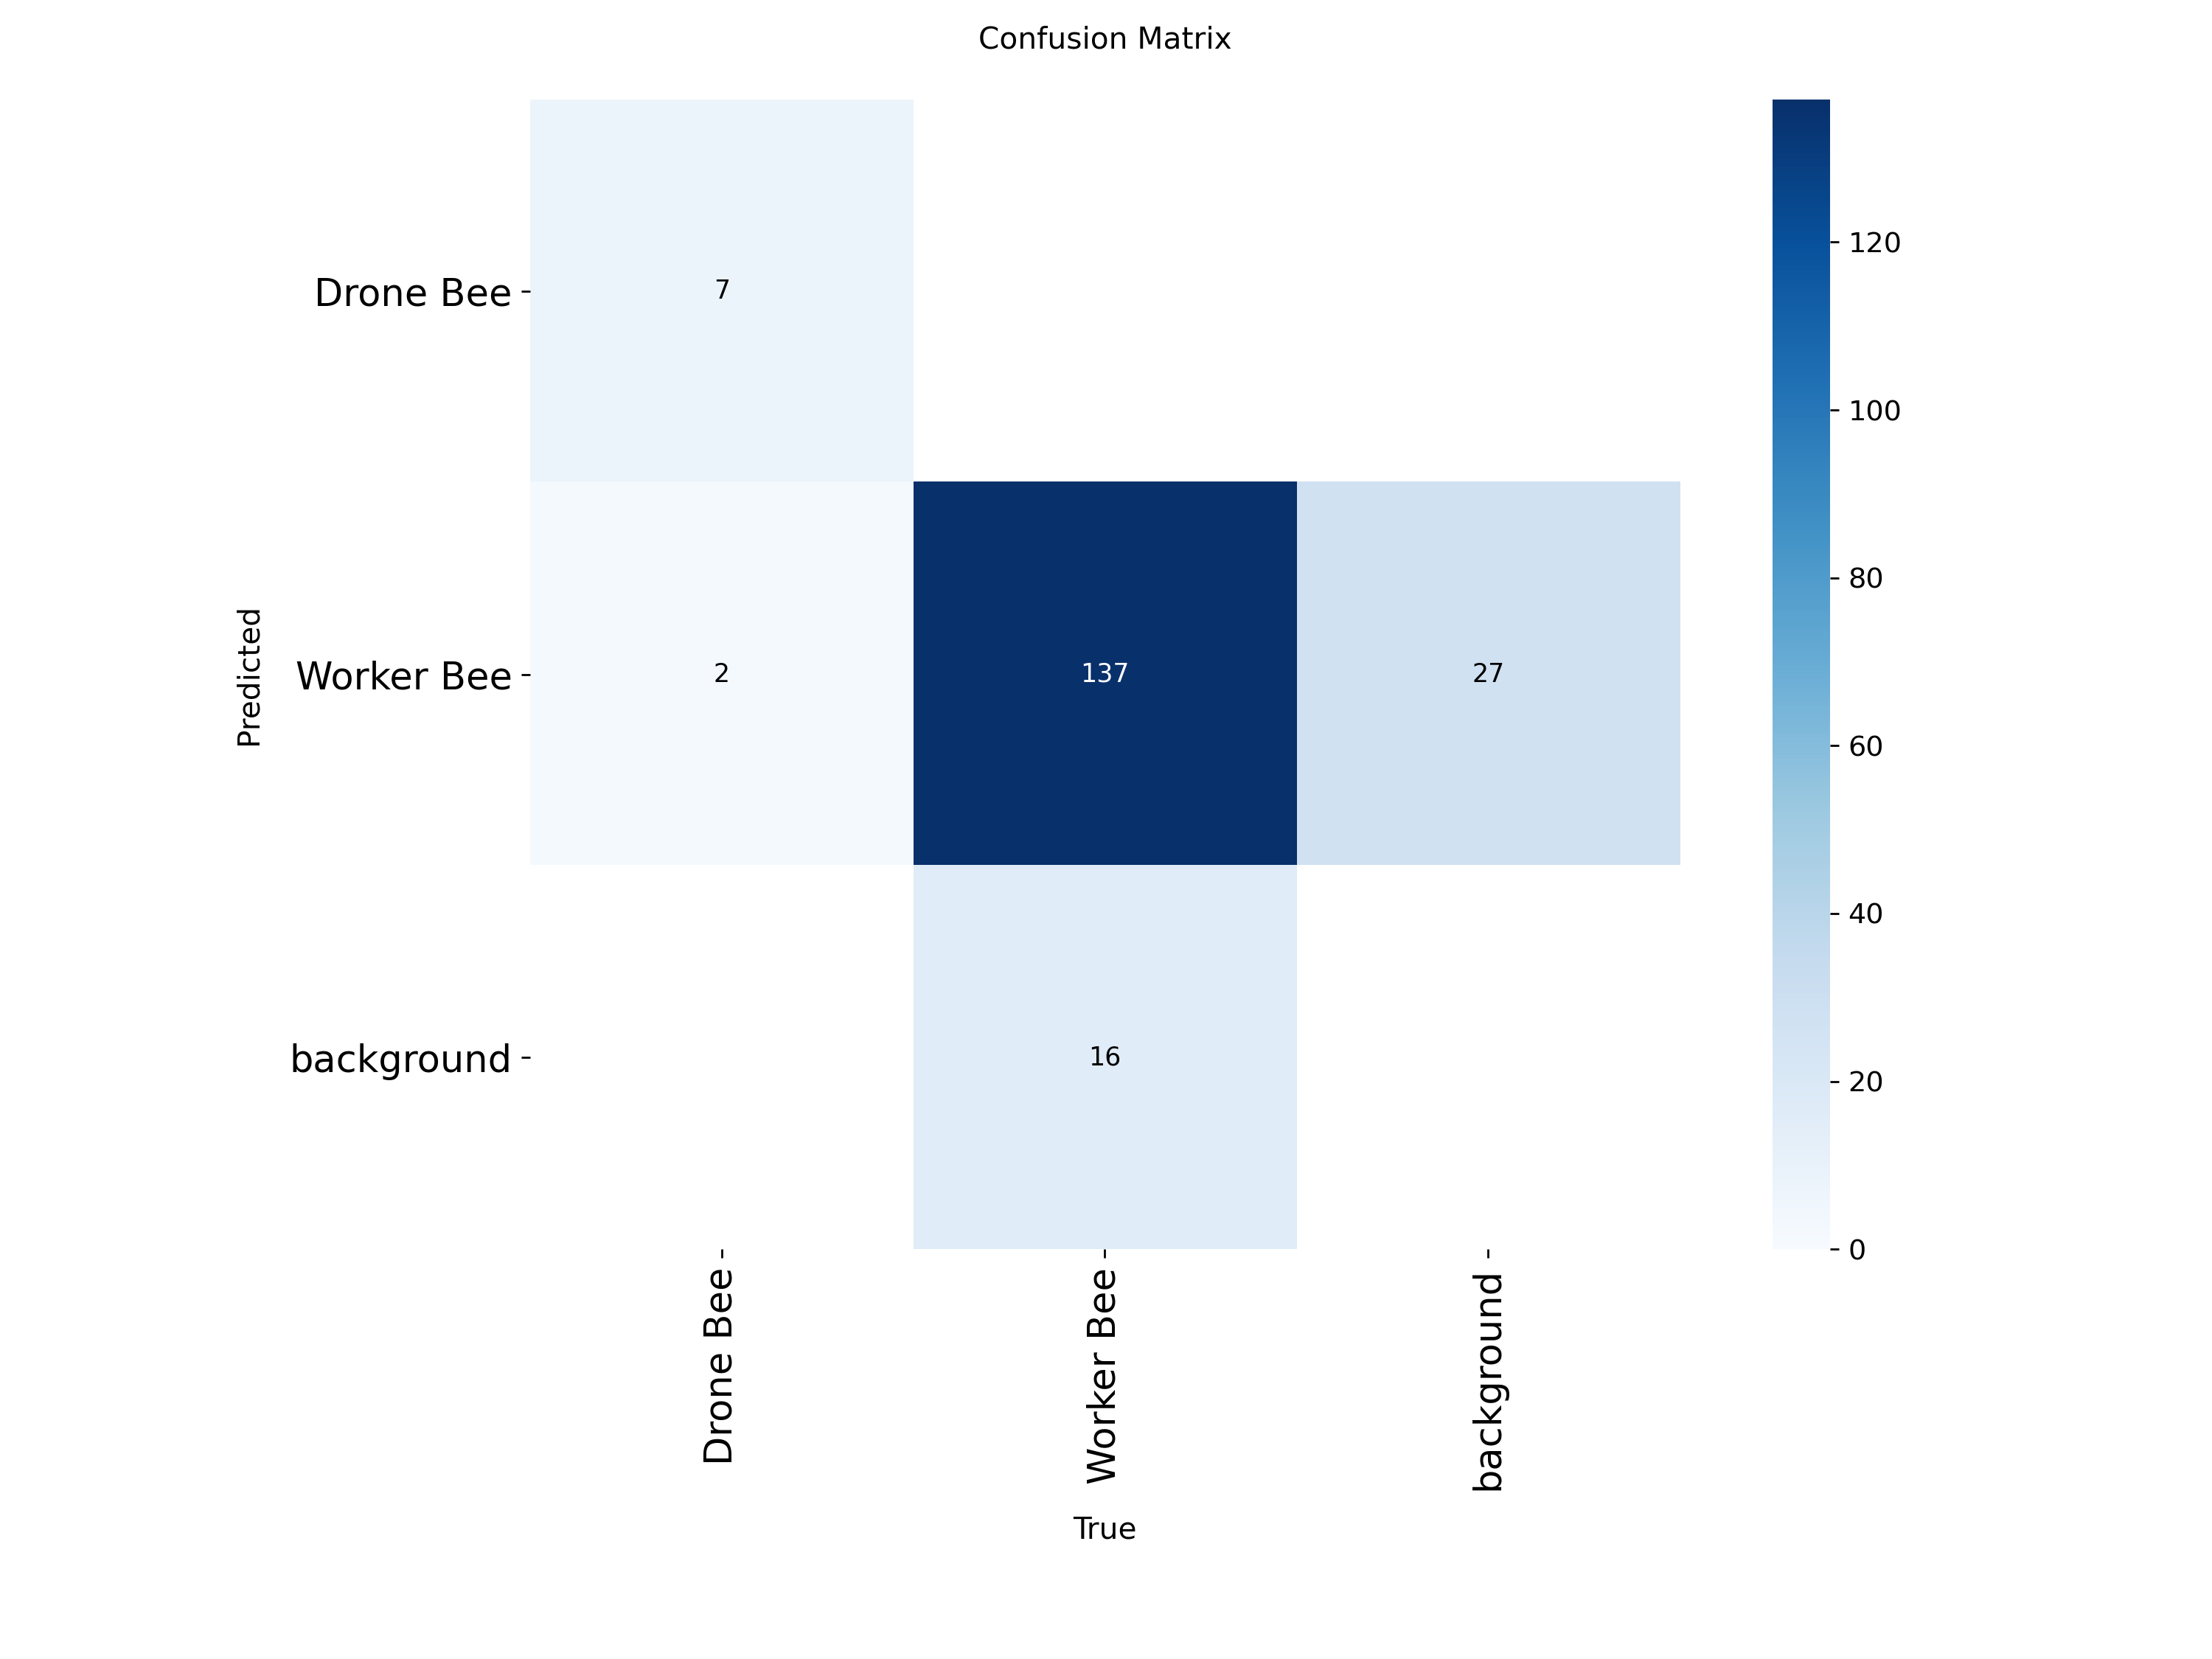

In [ ]:
# Shows performance on the 5 test images
confmat_path_2 = "/content/yolo_test_eval/bee_test_results2/confusion_matrix.png"
display(Image(filename=confmat_path_2))

In [ ]:
# visualizes predictions on test images
model.predict(
    source=str(base / "test" / "images"),
    conf=0.25,
    project="/content/yolo10_runs_version6",
    name="bee_preds",
    save=True
)

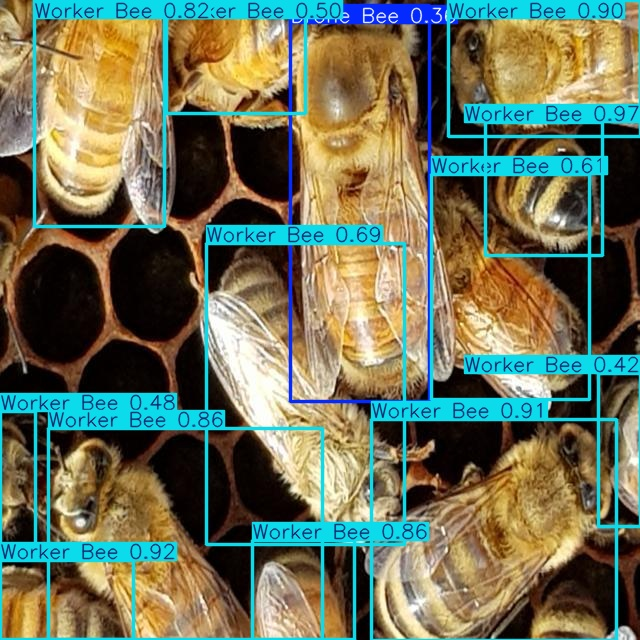

In [ ]:
confmat_path_3 = "/content/yolo10_runs_version6/bee_preds/Worker-Bees_jpg.rf.de9c0bb317a8f58aff48c97b02827e34.jpg"
display(Image(filename=confmat_path_3))